In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from collections import Counter
import collections
from pandas import DataFrame
from scipy.cluster.hierarchy import linkage, dendrogram

from pyspark.ml.recommendation import ALS
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SQLContext, Row

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt 

%matplotlib inline

# importing data

In [3]:
# personality scores
data1 = pd.read_excel('data/pers_scores_1098.xlsx')
# articles by some traveler
data2 = pd.read_excel('data/articles_159.xlsx')
# traveler profile
data3 = pd.read_excel('data/users_full_7034.xlsx')
# traveler and reviews
data4 = pd.read_excel('data/reviews_32618_for_1098_users_with_location.xlsx')


In [4]:
data1.head(5)

,username,open,cons,extra,agree,neuro
0,007solotraveler,0.63272,0.55666,0.56360,0.58108,0.45881
1,0BKI0,0.64006,0.55189,0.56220,0.57943,0.46188
2,10179k79,0.66435,0.56099,0.56880,0.58187,0.45011
3,124_10,0.66003,0.57005,0.57221,0.59019,0.44860
4,12ReasonsWhy,0.65036,0.55429,0.56510,0.58271,0.45919


In [5]:
data2.head(5)

,username,date,title,text,total_points
0,19katy80,2012-07-15,Why come to Manchester?,"Quite simply, whatever your interest, Manchest...",5
1,29grapes,2010-03-27,Taxis in Shanghai,Taxi companies in Shanghai are heavily regulat...,5
2,ALiEN2108,2011-11-03,Arriving & Departing,Airport Transfer FAQs answered:\nThere are two...,5
3,ASK_THE_LEYLANDS,2010-11-09,"HEYSEN AND MAWSON TRAILS, AUSTRALIA",Laura is small township situated in the Sout...,100
4,Alfanumeric,2013-12-06,Neighborhoods,City Centre\nWhile Americans cousins refer to ...,5


In [6]:
data3.head(3)

,username,ageRange,gender,location,travelStyle,reviewerBadge,registerDate,numHotelsReviews,numRestReviews,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
0,007solotraveler,35-49,male,liverpool,NaN,Contributor,2010-06-01,10.0,1.0,1.0,NaN,6.0,NaN,NaN,NaN,8.0,1240.0,3,10
1,0BKI0,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",Contributor,2009-08-01,11.0,7.0,NaN,NaN,1.0,10.0,NaN,NaN,11.0,2117.0,3,12
2,1010101,NaN,NaN,uk,NaN,NaN,2009-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0


In [7]:
data4.head(1)

,id,username,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,1,007solotraveler,Hotels,2013-04-08,Good Choice and would be suitable for a family,Decent Hotel next to station so good location ...,4,1.0,101,"Radisson Blu Royal Viking Hotel, Stockholm",http://www.tripadvisor.com/Hotel_Review-g18985...,Stockholm


# EDA
## data2 - articles

In [8]:
data2.text[8];

In [9]:
data2.head(10);

In [10]:
Counter(data3.numAttractReviews);

In [11]:
Counter(data4.type)

Counter({'Attractions': 5010, 'Hotels': 16699, 'Restaurants': 10871})

In [12]:
len(data4.taObjectCity.unique())

5927

In [13]:
Counter(data2.total_points)

Counter({5: 87, 100: 72})

## data3

In [14]:
#plt(data3.totalPoints);
import pylab
null_total_pt = data3.totalPoints.isnull()
#plt.hist(data3.totalPoints[~null_total_pt]);
#pylab.xlim([0,300000])
max_pt = data3.totalPoints[~null_total_pt].max()
max_pt
#plt.hist(data3.totalPoints[~null_total_pt].drop([5162]))
#max_2 = data3.totalPoints[~null_total_pt].drop([5162]).max()
#max_2
#plt.hist(data3.totalPoints[~null_total_pt].drop([5162,4829]);
#plt.hist( 1000 < data3.totalPoints[~null_total_pt] < 60000)

352444.0

In [15]:
data3.totalPoints[~null_total_pt].sort_values()[::-1];

In [16]:




# outlier - 352444.0 tripadvisor points
data3[data3.totalPoints == max_pt]

,username,ageRange,gender,location,travelStyle,reviewerBadge,registerDate,numHotelsReviews,numRestReviews,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
5162,jonotennis,35-49,male,NaN,NaN,Top Contributor,2011-02-01,90.0,179.0,198.0,51.0,2.0,10169.0,2.0,NaN,204.0,352444.0,6,619


In [17]:
# outlier - 236336.0 tripadvisor points
#data3[data3.totalPoints == max_2]

In [18]:
data3[data3.reviewerBadge == 'Top Contributor'];

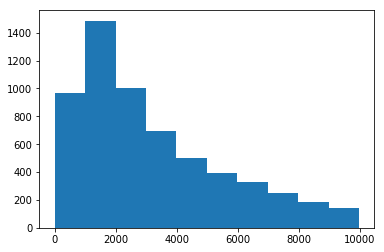

In [19]:
upper = (data3.totalPoints < 10000)
lower = (data3.totalPoints > 1000)
plt.hist(data3[upper].totalPoints);
#data3[upper].totalPoints

In [20]:
null_age = data3.ageRange.isnull()
null_gender = data3.gender.isnull()
null_style = data3.travelStyle.isnull()
#null

In [21]:
(data3[null_age].totalPoints < 1000).sum()

477

# data3 with total tripadvisor point > 1000 and no null age or gender

In [22]:
filtered_data3 = data3[data3.totalPoints > 1000][~null_age][~null_gender][~null_style]
filtered_data3.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,username,ageRange,gender,location,travelStyle,reviewerBadge,registerDate,numHotelsReviews,numRestReviews,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
1,0BKI0,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",Contributor,2009-08-01,11.0,7.0,NaN,NaN,1.0,10.0,NaN,NaN,11.0,2117.0,3,12
7,14beacon,35-49,male,"Wappingers Falls, New York","Foodie, Trendsetter, Like a Local, Luxury Trav...",Contributor,2009-03-01,7.0,2.0,2.0,NaN,NaN,1.0,NaN,NaN,10.0,1144.0,3,14
12,1975mark,25-34,male,"Huddersfield, United Kingdom","Foodie, Beach Goer, Thrifty Traveller, Nightli...",Senior Contributor,2010-06-01,12.0,15.0,NaN,4.0,NaN,NaN,NaN,NaN,13.0,2718.0,4,18
15,19Cam,25-34,male,"London, United Kingdom","Vegetarian, Urban Explorer, Art and Architectu...",Top Contributor,2010-05-01,58.0,28.0,8.0,NaN,2.0,12.0,1.0,NaN,49.0,9836.0,5,46
17,1Angie,18-24,female,"Melbourne, Australia","Beach Goer, Vegetarian, Urban Explorer",Senior Contributor,2010-08-01,20.0,5.0,8.0,3.0,NaN,11.0,NaN,NaN,18.0,3649.0,4,19


In [23]:
data3[data3.totalPoints > 1000][~null_age][~null_gender][~null_style].shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(2523, 19)

In [24]:
data3.numHelpfulVotes;

In [25]:
#Counter(data3.travelStyle.split(','))
data3.travelStyle.isnull().sum();
data3.travelStyle[~null_style].shape

styles_lst = []
for style in list(data3.travelStyle[data3.totalPoints > 1000][~null_age][~null_gender][~null_style]):
    item = style.split(', ')
    styles_lst.append(item)
    #print(styles)
    #styles_lst.extend(item)
    #print(styles_lst)
    
#print(styles_lst[:10])
newlist = [item for items in styles_lst for item in items]
Counter(newlist);
#print(len(Counter(newlist).keys()))
#scatter_matrix(Counter(newlist))


In [26]:
veg_lst = []
for item in styles_lst:
    if 'Vegetarian' in item:
        if len(item) < 4:
            veg_lst.append(item)
veg_lst[:10];


In [27]:
data3.travelStyle[~null_style].shape

(3502,)

## creating new column of list of travel styles

In [28]:
test_data3 = data3[data3.totalPoints > 1000][~null_style][~null_age][~null_gender]
#test_data3
#test_data3['new_travel_style'] = test_data3.travelStyle
#df = pd.get_dummies(test_data3, columns=['travelStyle'])
#df
style_lst2 = [item.split(', ') for item in test_data3.travelStyle]
style_lst2;
test_data3.shape


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(2523, 19)

In [29]:
test_data3['new_travel'] = style_lst2
#test_data3.new_travel
test_data3;
#df = pd.get_dummies(test_data3, columns=['new_travel'])
#df



## creating dummies for each travel style

In [30]:
travel_style = test_data3['new_travel'].apply(pd.Series) # 653 notes
travel_style_matrix = pd.get_dummies(travel_style.apply(pd.Series).stack()). \
sum(level=0).rename(columns = lambda x : 'travel_style_' + x)


In [31]:
travel_style_matrix.columns

Index(['travel_style_60+ Traveler', 'travel_style_Art and Architecture Lover',
       'travel_style_Backpacker', 'travel_style_Beach Goer',
       'travel_style_Eco-tourist', 'travel_style_Family Hoilday Maker',
       'travel_style_Foodie', 'travel_style_History Buff',
       'travel_style_Like a Local', 'travel_style_Luxury Traveller',
       'travel_style_Nature Lover', 'travel_style_Nightlife Seeker',
       'travel_style_Peace and Quiet Seeker', 'travel_style_Shopping Fanatic',
       'travel_style_Thrifty Traveller', 'travel_style_Thrill Seeker',
       'travel_style_Trendsetter', 'travel_style_Urban Explorer',
       'travel_style_Vegetarian'],
      dtype='object')

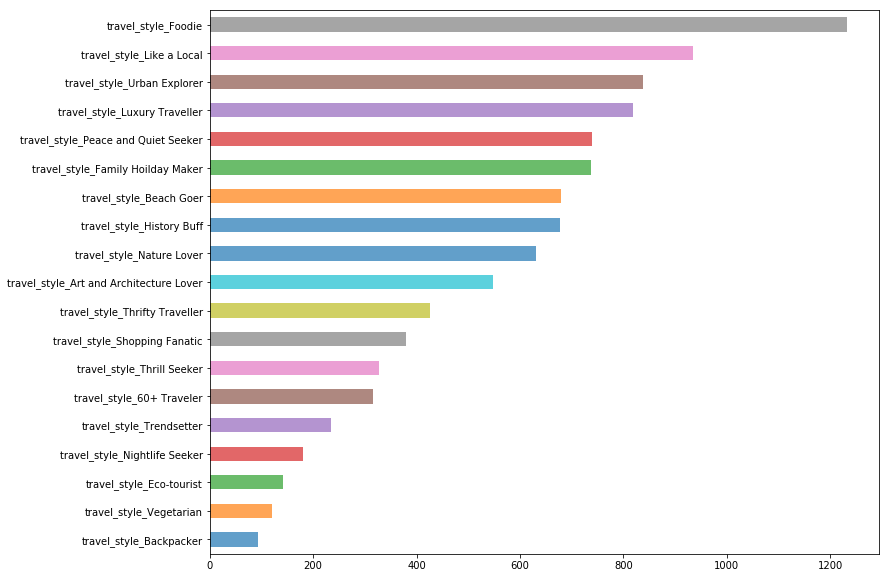

In [32]:
(travel_style_matrix.sum(axis=0)
                   .sort_values(ascending=True)
                   .plot(kind='barh',
                         figsize=(12,10),
                         alpha = .7));

In [33]:
travel_style_matrix;

In [35]:
#travel_style_matrix['travel_style_Luxury Traveller'].intersection(travel_style_matrix['travel_style_Shopping Fanatic'])

In [36]:
mask = travel_style_matrix

In [37]:
Counter(data3.contribLevel)

Counter({0: 85, 1: 17, 2: 943, 3: 2034, 4: 1655, 5: 1301, 6: 999})

# data 4 by reviews

In [38]:
mask = data4.username == '19katy80'
mask2 = data4.username == '1984travel'

In [39]:
new_mask = data4[mask].taObjectCity == 'Manchester'

In [40]:
data4[mask][new_mask];

In [41]:
bongo_mask = data4.username == 'Bongo_Craigy'

In [42]:
data4[bongo_mask].taObjectCity;

In [43]:
attrac_mask = data4.type == 'Attractions'
data4[attrac_mask][mask2];

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## data 1 - personality


In [44]:
data1_new = data1.drop(['username'], axis = 1);
data1_new.head()
#scatter_matrix(data1_new, figsize=(16, 12));

,open,cons,extra,agree,neuro
0,0.63272,0.55666,0.56360,0.58108,0.45881
1,0.64006,0.55189,0.56220,0.57943,0.46188
2,0.66435,0.56099,0.56880,0.58187,0.45011
3,0.66003,0.57005,0.57221,0.59019,0.44860
4,0.65036,0.55429,0.56510,0.58271,0.45919


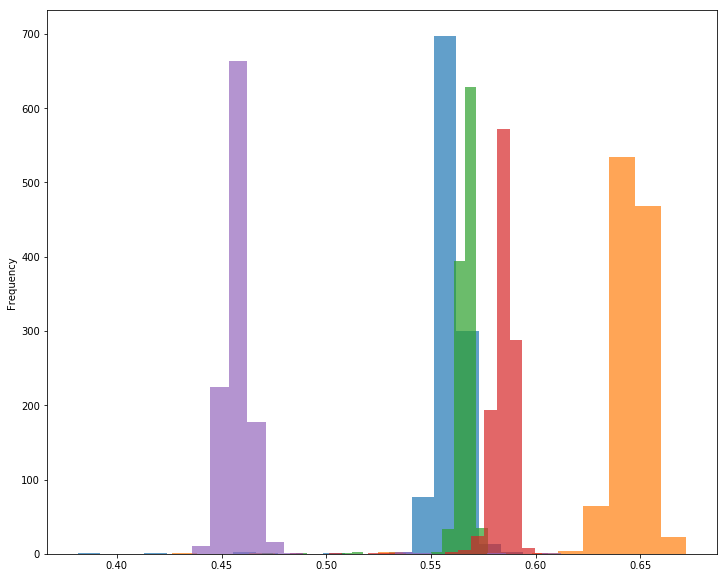

In [45]:
data1_new['cons'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_new['open'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_new['extra'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_new['agree'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_new['neuro'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);


# merging data1 - personality and data3- reviews

In [46]:
data1_and_3 = pd.merge(data1, filtered_data3, on=['username'])
data1_and_3.head(2)


,username,open,cons,extra,agree,neuro,ageRange,gender,location,travelStyle,...,numAttractReviews,numFirstToReview,numRatings,numPhotos,numForumPosts,numArticles,numCitiesBeen,totalPoints,contribLevel,numHelpfulVotes
0,0BKI0,0.64006,0.55189,0.56220,0.57943,0.46188,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",...,NaN,NaN,1.0,10.0,NaN,NaN,11.0,2117.0,3,12
1,14beacon,0.64359,0.56584,0.56965,0.59001,0.45454,35-49,male,"Wappingers Falls, New York","Foodie, Trendsetter, Like a Local, Luxury Trav...",...,2.0,NaN,NaN,1.0,NaN,NaN,10.0,1144.0,3,14


In [47]:
final_table = pd.merge(data1_and_3, data4, on=['username'])
final_table.head(2)

,username,open,cons,extra,agree,neuro,ageRange,gender,location,travelStyle,...,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,0BKI0,0.64006,0.55189,0.5622,0.57943,0.46188,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",...,Restaurants,2015-09-28,Unhygienic & terrible service,I have visited this restaurant twice before an...,1,0.0,100,Wahaca Bristol,http://www.tripadvisor.com/Restaurant_Review-g...,Bristol
1,0BKI0,0.64006,0.55189,0.5622,0.57943,0.46188,25-34,female,Bristol,"Foodie, Nature Lover, Urban Explorer",...,Restaurants,2015-06-30,Beautiful resturant overlooking the beach and ...,If you are in Alvor you must visit Canico! Bea...,5,1.0,101,Canico Restaurant,http://www.tripadvisor.com/Restaurant_Review-g...,Alvor


In [48]:
final_table.type.unique();

In [49]:
attra_mask_final = final_table.type == 'Attractions'

In [50]:
final_table_2 = final_table[attra_mask_final]


In [51]:
final_table_2.columns.values

array(['username', 'open', 'cons', 'extra', 'agree', 'neuro', 'ageRange',
       'gender', 'location', 'travelStyle', 'reviewerBadge',
       'registerDate', 'numHotelsReviews', 'numRestReviews',
       'numAttractReviews', 'numFirstToReview', 'numRatings', 'numPhotos',
       'numForumPosts', 'numArticles', 'numCitiesBeen', 'totalPoints',
       'contribLevel', 'numHelpfulVotes', 'id', 'type', 'date', 'title',
       'text', 'rating', 'helpfulness', 'total_points', 'taObject',
       'taObjectUrl', 'taObjectCity'], dtype=object)

In [52]:
final_table_2.shape;

# 109 cities have more than 4 reviews

In [53]:
#Counter(final_table_2.taObjectCity).values() > 2
pop_city = []
for item, value in Counter(final_table_2.taObjectCity).items():
    if value > 4:
        pop_city.append(item)
len(pop_city)
print(pop_city)

['Berlin', 'London', 'Kuala Lumpur', 'Brussels', 'Darwin', 'Chattanooga', 'St. Petersburg', 'Vienna', 'Athens', 'Granada', 'Barcelona', 'Madrid', 'Canberra', 'Washington DC', 'New York City', 'Montreal', 'Budapest', 'Santa Barbara', 'Sydney', 'Hanoi', 'Rome', 'Nashville', 'San Francisco', 'Dubai', 'Calgary', 'Quebec City', 'Chicago', 'Orlando', 'Anaheim', 'Lucerne', 'Amsterdam', 'Honolulu', 'Cologne', 'Paris', 'Monterey', 'Las Vegas', 'Boston', 'Yellowstone National Park', 'Bangkok', 'Lahaina', 'Helsinki', 'Hong Kong', 'Munich', 'Singapore', 'Vatican City', 'San Juan', 'Stratford-upon-Avon', 'Niagara Falls', 'Florence', 'Tallinn', 'Nice', 'Oxford', 'Reykjavik', 'Bergen', 'Venice', 'Key West', 'Atlanta', 'Miami', 'Los Angeles', 'Edinburgh', 'Belfast', 'Minato', 'Seattle', 'Brighton', 'Sentosa Island', 'Sao Paulo', 'Rio de Janeiro', 'Buenos Aires', 'Prague', 'Istanbul', 'Oslo', 'Manchester', 'Salzburg', 'Toronto', 'Naples', 'Lancaster', 'Moscow', 'Milan', 'Monte-Carlo', 'Hoi An', 'Warsaw

# group by cities then run NLP and then create city clusters

In [54]:
final_table_3 = final_table_2[final_table_2.taObjectCity.isin(pop_city)]
#df[~df.Species.isin(['Cat'])]

In [55]:
final_table_3 = final_table_3.reset_index()
final_table_3.head()
#final_table_3.shape

,index,username,open,cons,extra,agree,neuro,ageRange,gender,location,...,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,61,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,See it before its gone,The box is only a temporary exhibit while cons...,4,0.0,100,Humboldt Box,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
1,62,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,0.0,100,Neues Museum,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
2,77,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2013-11-09,Fantastic,"After reading all the hype about this show, I ...",5,0.0,100,The Book of Mormon London,http://www.tripadvisor.com/Attraction_Review-g...,London
3,113,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2013-01-27,Tranquility in a busy city,Sited within the main botanical gardens area o...,4,0.0,100,Orchid Park (Taman Orkid),http://www.tripadvisor.com/Attraction_Review-g...,Kuala Lumpur
4,131,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2012-06-25,"Tourist trap, some nice architecture",Not a lot to say. It&acute;s a big plaza. Not ...,3,1.0,101,Grand-Place,http://www.tripadvisor.com/Attraction_Review-g...,Brussels


In [56]:
#final_table_3.taObjectCity

In [57]:
reviews = final_table_3.title + ' ' + final_table_3.text
content = [i for i in reviews]
#content[:2]

In [58]:
def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(stop_words=('english'),
                                 max_features = 500,
                                 lowercase=True)
 
    tfidf_model = vectorizer.fit_transform(texts)
    vectors = tfidf_model.toarray()
    cols = vectorizer.get_feature_names()
    
    #print(vectors[0][100:200])
    #print(cols[100:190])
    return (vectors, cols)
    
#     km_model = KMeans(n_clusters=clusters)
#     km_model.fit(tfidf_model)
 
#     clustering = collections.defaultdict(list)
 
#     for idx, label in enumerate(km_model.labels_):
#         clustering[label].append(idx)
 
#     return clustering
def _cluster(vectors, cols, texts):
    """
    Cluster vecotirzed reviews and create k books a data frame relating the
    k label to the book id
    """
    kmeans = KMeans(n_clusters=5).fit(vectors)
    k_books = pd.DataFrame(list(zip(list(kmeans.labels_),
                                list(texts.index))),
                                columns=['k_label', 'book_id'])
    
    ''' added code to print centriod vocab - Print the top n words from all centroids vocab
    '''
    n = 30
    centroids = kmeans.cluster_centers_
    for ind, c in enumerate(centroids):
        print(ind)
        indices = c.argsort()[-1:-n-1:-1]
        print([cols[i] for i in indices])
        print("=="*20)
    
    return k_books

In [59]:
#from pprint import pprint
vector, cols = cluster_texts(content, 5)
cluster_df = _cluster(vector, cols, reviews)

0
['para', 'da', 'em', 'um', 'local', 'central', 'hotel', 'shows', 'enjoy', 'disney', 'grand', 'chance', 'stand', 'exhibition', 'visitors', 'rock', 'exhibits', 'park', 'huge', 'center', 'shopping', 'little', 'time', 'falls', 'souvenirs', '20', 'place', '30', 'city', 'acute']
1
['worth', 'visit', 'good', 'just', 'walk', 'time', 'beautiful', 'building', 'amazing', 'view', 'day', 'really', 'interesting', 'views', 'museum', 'acute', 'people', 'experience', 'inside', 'nice', 'city', 'like', 'history', 'best', 'tickets', 'area', 'bridge', 'way', 'impressive', 'collection']
2
['great', 'place', 'nice', 'park', 'lovely', 'beautiful', 'fun', 'visit', 'acute', 'food', 'lots', 'good', 'loved', 'shops', 'excellent', 'area', 'day', 'old', 'walk', 'time', 'really', 'walking', 'enjoyed', 'view', 'just', 'town', 'night', 'spend', 'restaurants', 'enjoy']
3
['tour', 'guide', 'acute', 'good', 'bus', 'fun', 'really', 'great', 'time', 'city', 'day', 'tours', 'did', 'interesting', 'history', 'way', 'knowled

In [60]:
cluster_df.head(10);
#cluster_df.shape

In [61]:
cluster2_mask = (cluster_df['k_label'] == 2)
cluster0_mask = (cluster_df['k_label'] == 0)
cluster3_mask = (cluster_df['k_label'] == 3)
#cluster2_mask

In [62]:
#cluster_df[cluster2_mask].head(20);
#cluster_df[cluster0_mask][:-10];
cluster_df[cluster3_mask][100:120];

In [63]:
# from cluster 2
final_table_3.iloc[[0, 5, 6, 9, 15, 17]];
# Berlin, Darwin, London

# from cluster 0
final_table_3.iloc[[278, 279, 280, 611, 612, 986, 987]]
# Sao Paulo, Quebec City, Rio de Janeiro, Orlando

# from cluster 3
final_table_3.iloc[[229, 230, 233, 300, 971, 1039, 1115]];
# Atlanta, Niagara Falls, Bergen, New York City, Las Vegas, Reykjavik

In [64]:
# def print_centroid_vocab(self, n):
#     """
#     Print the top n words from all centroids vocab
#     """
#     centroids = self.kmeans.cluster_centers_
#     for ind, c in enumerate(centroids):
#         print(ind)
#         indices = c.argsort()[-1:-n-1:-1]
#         print([self.cols[i] for i in indices])
#         print("=="*20)

# ALS model?

## create spark dataframe

In [65]:
# Build our Spark Session and Context

spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc
sqlContext = SQLContext(sc)

In [66]:
#ratings_df = spark.createDataFrame(.drop('timestamp', axis=1))

In [67]:
np.linalg.svd?


In [68]:
final_table_3.head()

,index,username,open,cons,extra,agree,neuro,ageRange,gender,location,...,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,61,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,See it before its gone,The box is only a temporary exhibit while cons...,4,0.0,100,Humboldt Box,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
1,62,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,0.0,100,Neues Museum,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
2,77,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2013-11-09,Fantastic,"After reading all the hype about this show, I ...",5,0.0,100,The Book of Mormon London,http://www.tripadvisor.com/Attraction_Review-g...,London
3,113,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2013-01-27,Tranquility in a busy city,Sited within the main botanical gardens area o...,4,0.0,100,Orchid Park (Taman Orkid),http://www.tripadvisor.com/Attraction_Review-g...,Kuala Lumpur
4,131,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2012-06-25,"Tourist trap, some nice architecture",Not a lot to say. It&acute;s a big plaza. Not ...,3,1.0,101,Grand-Place,http://www.tripadvisor.com/Attraction_Review-g...,Brussels


In [69]:
temp_rdd = final_table_3[['username', 'taObjectCity', 'rating']]

In [70]:
temp_rdd;

In [71]:
len(temp_rdd.username.unique())

234

## creating user dictionary with key = user, values = id/index

In [72]:

user_dict = {}
for idx, user in enumerate(temp_rdd.username.unique()):
    user_dict[user] = idx
    
user_dict;
    

In [73]:
user_id_list = [user_dict[item] 
                  for user in temp_rdd.username for item, key in user_dict.items() 
                  if item == user]

In [74]:
temp_rdd['user_id'] = user_id_list

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
temp_rdd.head()

,username,taObjectCity,rating,user_id
0,19Cam,Berlin,4,0
1,19Cam,Berlin,3,0
2,19Cam,London,5,0
3,19Cam,Kuala Lumpur,4,0
4,19Cam,Brussels,3,0


In [76]:
len(user_id_list) == len(temp_rdd.username)

True

In [77]:
len(temp_rdd.taObjectCity.unique())

109

## creating city dictionary with key = city, values =id/index

In [78]:
city_dict = {}
for idx, city in enumerate(temp_rdd.taObjectCity.unique()):
    city_dict[city] = idx
    
city_dict;

In [79]:
city_id_list_2 = [city_dict[item] for city in temp_rdd.taObjectCity 
                  for item, key in city_dict.items() if item == city]

In [80]:
# make sure each city has an id

len(temp_rdd.taObjectCity) == len(city_id_list_2)

True

In [81]:
temp_rdd.head(20);


In [82]:
# city_id_list = []
# for city in temp_rdd.taObjectCity :
#     #print(city)
#     for item, key in city_dict.items():
#         if item == city:
#             city_id_list.append(city_dict[item])
#             #print('item:', item, 'idx:',city_dict[item])



In [83]:
temp_rdd['city_id'] = city_id_list_2

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [84]:
new_temp_rdd = temp_rdd[['user_id', 'city_id', 'rating']]
new_temp_rdd['rating_float'] = pd.to_numeric(new_temp_rdd.rating, downcast='float');
new_temp_rdd['rating_float']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0       4.0
1       3.0
2       5.0
3       4.0
4       3.0
5       5.0
6       2.0
7       4.0
8       5.0
9       3.0
10      5.0
11      5.0
12      5.0
13      5.0
14      5.0
15      4.0
16      4.0
17      4.0
18      5.0
19      5.0
20      2.0
21      3.0
22      4.0
23      5.0
24      4.0
25      4.0
26      5.0
27      5.0
28      4.0
29      5.0
       ... 
1244    5.0
1245    3.0
1246    5.0
1247    3.0
1248    5.0
1249    4.0
1250    5.0
1251    5.0
1252    5.0
1253    5.0
1254    4.0
1255    5.0
1256    5.0
1257    5.0
1258    5.0
1259    5.0
1260    5.0
1261    5.0
1262    5.0
1263    5.0
1264    4.0
1265    5.0
1266    5.0
1267    4.0
1268    4.0
1269    4.0
1270    2.0
1271    1.0
1272    1.0
1273    2.0
Name: rating_float, Length: 1274, dtype: float32

In [85]:
new_temp_rdd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 4 columns):
user_id         1274 non-null int64
city_id         1274 non-null int64
rating          1274 non-null int64
rating_float    1274 non-null float32
dtypes: float32(1), int64(3)
memory usage: 34.9 KB


In [86]:
new_new_temp_rdd = new_temp_rdd[['user_id','city_id','rating_float']]

In [87]:
new_new_temp_rdd.head()

,user_id,city_id,rating_float
0,0,0,4.0
1,0,0,3.0
2,0,1,5.0
3,0,2,4.0
4,0,3,3.0


In [88]:
# schema = StructType( [ 
#     StructField('user', StringType(), True),
#     StructField('city', StringType(), True),
#     StructField('rating', IntegerType(), True)]
# )

schema = StructType( [ 
    StructField('user', IntegerType(), True),
    StructField('city', IntegerType(), True),
    StructField('rating', FloatType(), True)]
)

In [89]:
sp_df = sqlContext.createDataFrame(new_new_temp_rdd, schema)
sp_df.take(10);


In [90]:
type(sp_df)

pyspark.sql.dataframe.DataFrame

In [91]:
#ratings_df = spark.createDataFrame(sp_df, schema)


In [92]:
train, test = sp_df.randomSplit([0.8, 0.2], seed=427471138)
train.show(10);

+----+----+------+
|user|city|rating|
+----+----+------+
|   0|   0|   4.0|
|   0|   1|   5.0|
|   0|   2|   4.0|
|   1|   4|   3.0|
|   1|   4|   5.0|
|   1|   4|   5.0|
|   2|   5|   5.0|
|   2|   5|   5.0|
|   2|   5|   5.0|
|   2|   6|   5.0|
+----+----+------+
only showing top 10 rows



# ALS model!!!!

In [93]:
als_model = ALS(userCol='user',
                itemCol='city',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=20
               )

In [94]:
recommender = als_model.fit(train)
recommender

ALS_475ba9925a855bae928f

In [95]:
predictions = recommender.transform(test)


In [96]:
predictions.show(20)

+----+----+------+----------+
|user|city|rating|prediction|
+----+----+------+----------+
| 102|  31|   5.0|   4.99757|
|  75|  31|   4.0|  4.932624|
|  75|  31|   4.0|  4.932624|
|  11|  31|   4.0|       NaN|
|  11|  31|   5.0|       NaN|
| 186|  31|   4.0| 3.1562424|
| 186|  31|   4.0| 3.1562424|
| 217|  85|   5.0| 4.4304533|
|  77|  85|   5.0|  4.741751|
|  37|  65|   4.0| 4.4578276|
| 175|  65|   4.0| 4.9368014|
|  92|  53|   5.0|  3.016919|
|  41|  53|   5.0| 4.7921405|
|  24|  53|   5.0|  3.594255|
| 131|  53|   5.0| 2.8895087|
| 221| 108|   5.0| 4.1495266|
| 199| 101|   4.0| 3.0166473|
| 115|  81|   5.0| 4.8759766|
| 232|  28|   4.0| 4.0046763|
|   9|  28|   4.0|  4.400531|
+----+----+------+----------+
only showing top 20 rows



In [97]:
col = predictions.rating-predictions.prediction

In [98]:
df_pred = predictions.toPandas()

In [99]:
pred = df_pred.prediction
actual = df_pred.rating

In [100]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(actual, pred.fillna(3))

## mse 

In [101]:
print(np.sqrt(mse))

1.1116654


# hybrid recommender! - combo of utility matrix and user-only matrix

## user-only matrix

In [102]:
final_table_3.head(2)

,index,username,open,cons,extra,agree,neuro,ageRange,gender,location,...,type,date,title,text,rating,helpfulness,total_points,taObject,taObjectUrl,taObjectCity
0,61,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,See it before its gone,The box is only a temporary exhibit while cons...,4,0.0,100,Humboldt Box,http://www.tripadvisor.com/Attraction_Review-g...,Berlin
1,62,19Cam,0.64198,0.55524,0.56619,0.58622,0.46087,25-34,male,"London, United Kingdom",...,Attractions,2015-09-04,Worth a look for the architecture alone,"A large collection, presented in a stunning bu...",3,0.0,100,Neues Museum,http://www.tripadvisor.com/Attraction_Review-g...,Berlin


In [103]:
final_table_3.columns

Index(['index', 'username', 'open', 'cons', 'extra', 'agree', 'neuro',
       'ageRange', 'gender', 'location', 'travelStyle', 'reviewerBadge',
       'registerDate', 'numHotelsReviews', 'numRestReviews',
       'numAttractReviews', 'numFirstToReview', 'numRatings', 'numPhotos',
       'numForumPosts', 'numArticles', 'numCitiesBeen', 'totalPoints',
       'contribLevel', 'numHelpfulVotes', 'id', 'type', 'date', 'title',
       'text', 'rating', 'helpfulness', 'total_points', 'taObject',
       'taObjectUrl', 'taObjectCity'],
      dtype='object')

In [104]:
user_feature_df = final_table_3[['index', 'username','ageRange', 'gender','travelStyle']]

In [105]:
travel_style_lst = [item.split(', ') for item in user_feature_df.travelStyle]
user_feature_df['new_travel'] = travel_style_lst

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [106]:
travel_style_revised = user_feature_df['new_travel'].apply(pd.Series) # 653 notes
travel_style_matrix_revised = pd.get_dummies(travel_style_revised.apply(pd.Series).stack()).sum(level=0).rename(columns = lambda x : 'travel_style_' + x)

In [107]:
travel_style_matrix_revised = travel_style_matrix_revised.drop(['travel_style_Foodie', 'travel_style_60+ Traveler'], axis=1)
travel_style_matrix_revised

,travel_style_Art and Architecture Lover,travel_style_Backpacker,travel_style_Beach Goer,travel_style_Eco-tourist,travel_style_Family Hoilday Maker,travel_style_History Buff,travel_style_Like a Local,travel_style_Luxury Traveller,travel_style_Nature Lover,travel_style_Nightlife Seeker,travel_style_Peace and Quiet Seeker,travel_style_Shopping Fanatic,travel_style_Thrifty Traveller,travel_style_Thrill Seeker,travel_style_Trendsetter,travel_style_Urban Explorer,travel_style_Vegetarian
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1
9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [108]:
#travel_style_matrix_revised.isnull()

In [109]:
# travel_style_matrix_revised['travel_style_Veg_or_eco'] = (travel_style_matrix_revised['travel_style_Vegetarian'] 
# + travel_style_matrix_revised['travel_style_Eco-tourist'])
# more_than_two_mask = travel_style_matrix_revised['travel_style_Veg_or_eco'] == 2

In [110]:
#travel_style_matrix_revised[more_than_two_mask]

In [111]:
mask = (travel_style_matrix_revised['travel_style_Nature Lover'] == 1) 
#| (travel_style_matrix_revised['travel_style_Eco-tourist'] == 1)

In [112]:
travel_style_matrix_revised[mask].sum()

travel_style_Art and Architecture Lover    174
travel_style_Backpacker                     19
travel_style_Beach Goer                    141
travel_style_Eco-tourist                    21
travel_style_Family Hoilday Maker          176
travel_style_History Buff                  200
travel_style_Like a Local                  262
travel_style_Luxury Traveller              107
travel_style_Nature Lover                  451
travel_style_Nightlife Seeker               35
travel_style_Peace and Quiet Seeker        146
travel_style_Shopping Fanatic              135
travel_style_Thrifty Traveller              93
travel_style_Thrill Seeker                 135
travel_style_Trendsetter                    54
travel_style_Urban Explorer                138
travel_style_Vegetarian                      8
dtype: int64

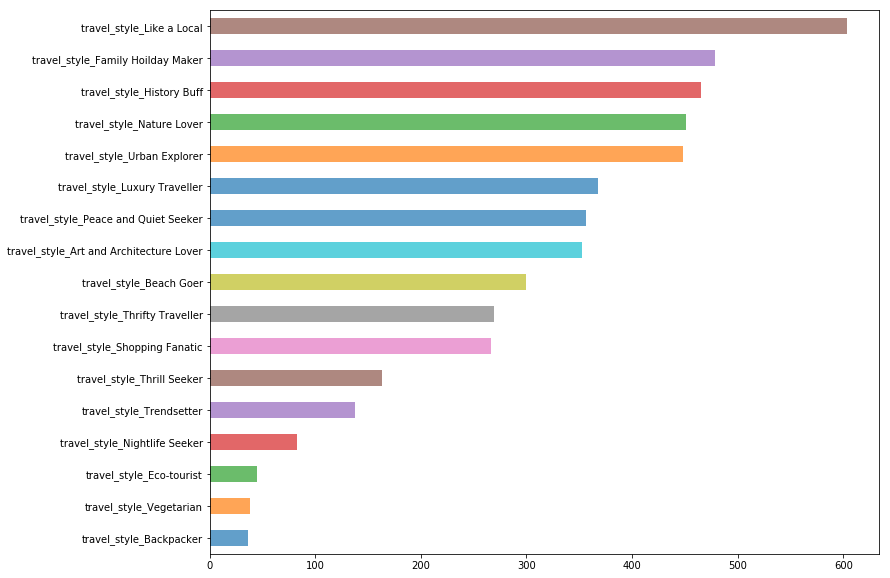

In [113]:
(travel_style_matrix_revised.sum(axis=0)
                   .sort_values(ascending=True)
                   .plot(kind='barh',
                         figsize=(12,10),
                         alpha = .7));

In [114]:
df_age_gender = final_table_3[['ageRange', 'gender']]
#df_age_gender.ageRange

In [115]:
df_age_gender = pd.get_dummies(df_age_gender, columns = ['ageRange'])

In [116]:
#df = pd.get_dummies(df, columns=['type'])


In [117]:
df_age_gender = pd.get_dummies(df_age_gender, columns = ['gender'])


In [118]:
left = df_age_gender
right = travel_style_matrix_revised

In [119]:
user_feat_df = left.join(right)

In [141]:
user_feat_df.shape

(1274, 24)

In [143]:
user_feat_df.shape

(1274, 24)

In [121]:
from sklearn.metrics import jaccard_similarity_score

In [122]:
user_feat_df_T = user_feat_df.T

In [123]:
jaccard_similarity_score(user_feat_df_T[0], user_feat_df_T[27])

0.6666666666666666

In [124]:
new_new_temp_rdd.head()

,user_id,city_id,rating_float
0,0,0,4.0
1,0,0,3.0
2,0,1,5.0
3,0,2,4.0
4,0,3,3.0


In [140]:
user_temp = new_new_temp_rdd[['user_id']]

df_user_id = pd.DataFrame(user_temp.user_id.unique(),columns=['user_id'])
df_user_id.head()

,user_id
0,0
1,1
2,2
3,3
4,4


# creating a matri

In [128]:
# filtered data number of unique cities
len(final_table_2.taObjectCity.unique())
#Counter(final_table[attra_mask_final].taObjectCity.unique())

1002

In [129]:
# original number of unique cities from data4
len(data4.taObjectCity.unique());

In [130]:
print(data1_new['cons'].mean())
print(data1_new['open'].mean())
print(data1_new['extra'].mean())
print(data1_new['agree'].mean())
print(data1_new['neuro'].mean())
print('----------filtered-------------')
print(data1_and_3['cons'].mean())
print(data1_and_3['open'].mean())
print(data1_and_3['extra'].mean())
print(data1_and_3['agree'].mean())
print(data1_and_3['neuro'].mean())

0.5588666575591985
0.6454380874316942
0.5664736976320587
0.5843303551912571
0.4581243078324227
----------filtered-------------
0.5585416452442162
0.6452703084832903
0.5661756298200515
0.583772673521851
0.4584064267352185


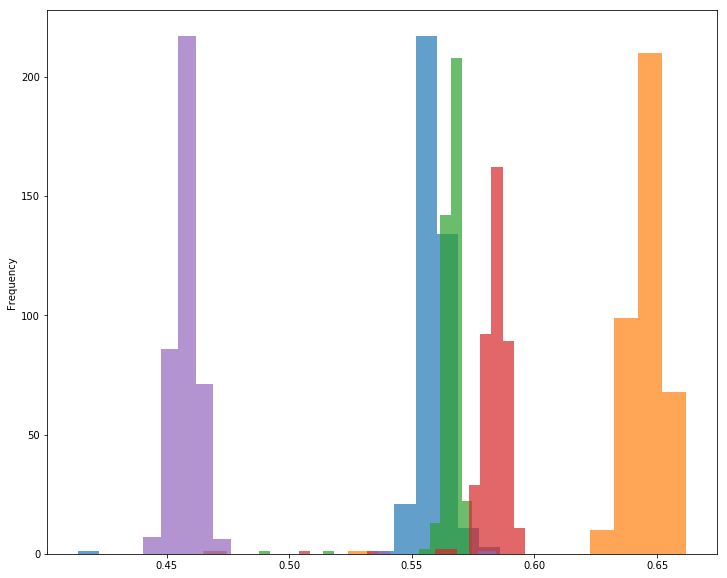

In [131]:

data1_and_3['cons'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_and_3['open'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_and_3['extra'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_and_3['agree'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);
data1_and_3['neuro'].plot(kind='hist', bins=20, figsize=(12,10), alpha = .7);

# NLP

In [132]:
documents = data2.text[0].split('.')
cv = CountVectorizer(stop_words='english')
vectorized = cv.fit_transform(documents)

In [133]:
manchester_dict = cv.vocabulary_

In [134]:
documents2 = data2.text[1].split('.')
tfid2 = CountVectorizer(stop_words='english')
vectorized2 = tfid2.fit_transform(documents2)

In [135]:
features = tfid2.get_feature_names()
features;
#row = wiki_data.index.get_loc(name)

In [136]:
#vectorized2.shape
#d = pd.Series(vectorized2.toarray(), index = features)
#sort_values(ascending=False)
#vectorized2.toarray()
freqs = zip(tfid2.get_feature_names(), vectorized2.sum(axis=0))    
sorted(freqs, key=lambda x: -x[1]);

In [137]:
shanghai_dict = sorted(cv2.vocabulary_.items(), key = itemgetter(1), reverse = True)
#dct.items(), key=

NameError: name 'cv2' is not defined

In [ ]:
from collections import OrderedDict
from operator import itemgetter

In [ ]:
manchester_dict = sorted(cv.vocabulary_.items(), key = itemgetter(1), reverse = True)

In [ ]:
manchester_dict[:30];

In [ ]:
Counter(' '.join(documents).split()).most_common()[:30];